In [23]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import shapiro, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [24]:
file_path = "/content/drive/MyDrive/MLR503 Final Exam Preparation/Time series based stuff/synthetic_time_series_electricity.csv"

In [25]:
data = pd.read_csv(file_path)

In [26]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [27]:
data

,Timestamp,City_ID,Temperature,Humidity,Electricity_Consumption
0,2020-01-01 00:00:00,City_A,24.967142,72.735620,61.681097
1,2020-01-01 01:00:00,City_A,18.617357,67.192112,48.703586
2,2020-01-01 02:00:00,City_A,26.476885,75.817570,50.653559
3,2020-01-01 03:00:00,City_A,35.230299,67.415056,59.394827
4,2020-01-01 04:00:00,City_A,17.658466,76.803782,46.447203
...,...,...,...,...,...
131400,2022-12-30 20:00:00,City_E,21.282418,69.089393,51.720288
131401,2022-12-30 21:00:00,City_E,19.795587,53.001084,45.116246
131402,2022-12-30 22:00:00,City_E,28.688692,68.796075,66.588651
131403,2022-12-30 23:00:00,City_E,23.197479,41.352762,49.731913


In [28]:
print("Missing values before handling:")
print(data.isnull().sum())

Missing values before handling:
Timestamp                  0
City_ID                    0
Temperature                0
Humidity                   0
Electricity_Consumption    0
dtype: int64


In [29]:
from sklearn.preprocessing import LabelEncoder

# Ensure the City_ID column exists
if 'City_ID' in data.columns:
    # Initialize the label encoder
    label_encoder = LabelEncoder()

    # Apply label encoding
    data['City_ID'] = label_encoder.fit_transform(data['City_ID'])

    print("City_ID converted to numerical values.")
    print("Mapping of labels:")
    print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
else:
    print("Error: 'City_ID' column not found in the dataset!")


City_ID converted to numerical values.
Mapping of labels:
{'City_A': 0, 'City_B': 1, 'City_C': 2, 'City_D': 3, 'City_E': 4}


In [30]:
data

,Timestamp,City_ID,Temperature,Humidity,Electricity_Consumption
0,2020-01-01 00:00:00,0,24.967142,72.735620,61.681097
1,2020-01-01 01:00:00,0,18.617357,67.192112,48.703586
2,2020-01-01 02:00:00,0,26.476885,75.817570,50.653559
3,2020-01-01 03:00:00,0,35.230299,67.415056,59.394827
4,2020-01-01 04:00:00,0,17.658466,76.803782,46.447203
...,...,...,...,...,...
131400,2022-12-30 20:00:00,4,21.282418,69.089393,51.720288
131401,2022-12-30 21:00:00,4,19.795587,53.001084,45.116246
131402,2022-12-30 22:00:00,4,28.688692,68.796075,66.588651
131403,2022-12-30 23:00:00,4,23.197479,41.352762,49.731913


There are no missing values here, so we're good. But it would be a good idea to have a dataset that specifically has missing values so we know how to deal with them as well. This is a problem for later.

In [31]:
# 2. Handle outliers
# Define a function to clip outliers beyond 1.5*IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[column].clip(lower_bound, upper_bound)

In [32]:
data['Electricity_Consumption'] = remove_outliers(data, 'Electricity_Consumption')

In [33]:
data

,Timestamp,City_ID,Temperature,Humidity,Electricity_Consumption
0,2020-01-01 00:00:00,0,24.967142,72.735620,61.681097
1,2020-01-01 01:00:00,0,18.617357,67.192112,48.703586
2,2020-01-01 02:00:00,0,26.476885,75.817570,50.653559
3,2020-01-01 03:00:00,0,35.230299,67.415056,59.394827
4,2020-01-01 04:00:00,0,17.658466,76.803782,46.447203
...,...,...,...,...,...
131400,2022-12-30 20:00:00,4,21.282418,69.089393,51.720288
131401,2022-12-30 21:00:00,4,19.795587,53.001084,45.116246
131402,2022-12-30 22:00:00,4,28.688692,68.796075,66.588651
131403,2022-12-30 23:00:00,4,23.197479,41.352762,49.731913


In [34]:
scaler = MinMaxScaler()
data[['Temperature', 'Humidity', 'Electricity_Consumption']] = scaler.fit_transform(
    data[['Temperature', 'Humidity', 'Electricity_Consumption']]
)

In [39]:
train_data = data[data['Timestamp'] < '2022-10-10']
test_data = data[data['Timestamp'] >= '2022-10-10']

In [40]:
print(f"Training Data Size: {train_data.shape}")
print(f"Testing Data Size: {test_data.shape}")

Training Data Size: (121560, 5)
Testing Data Size: (9845, 5)


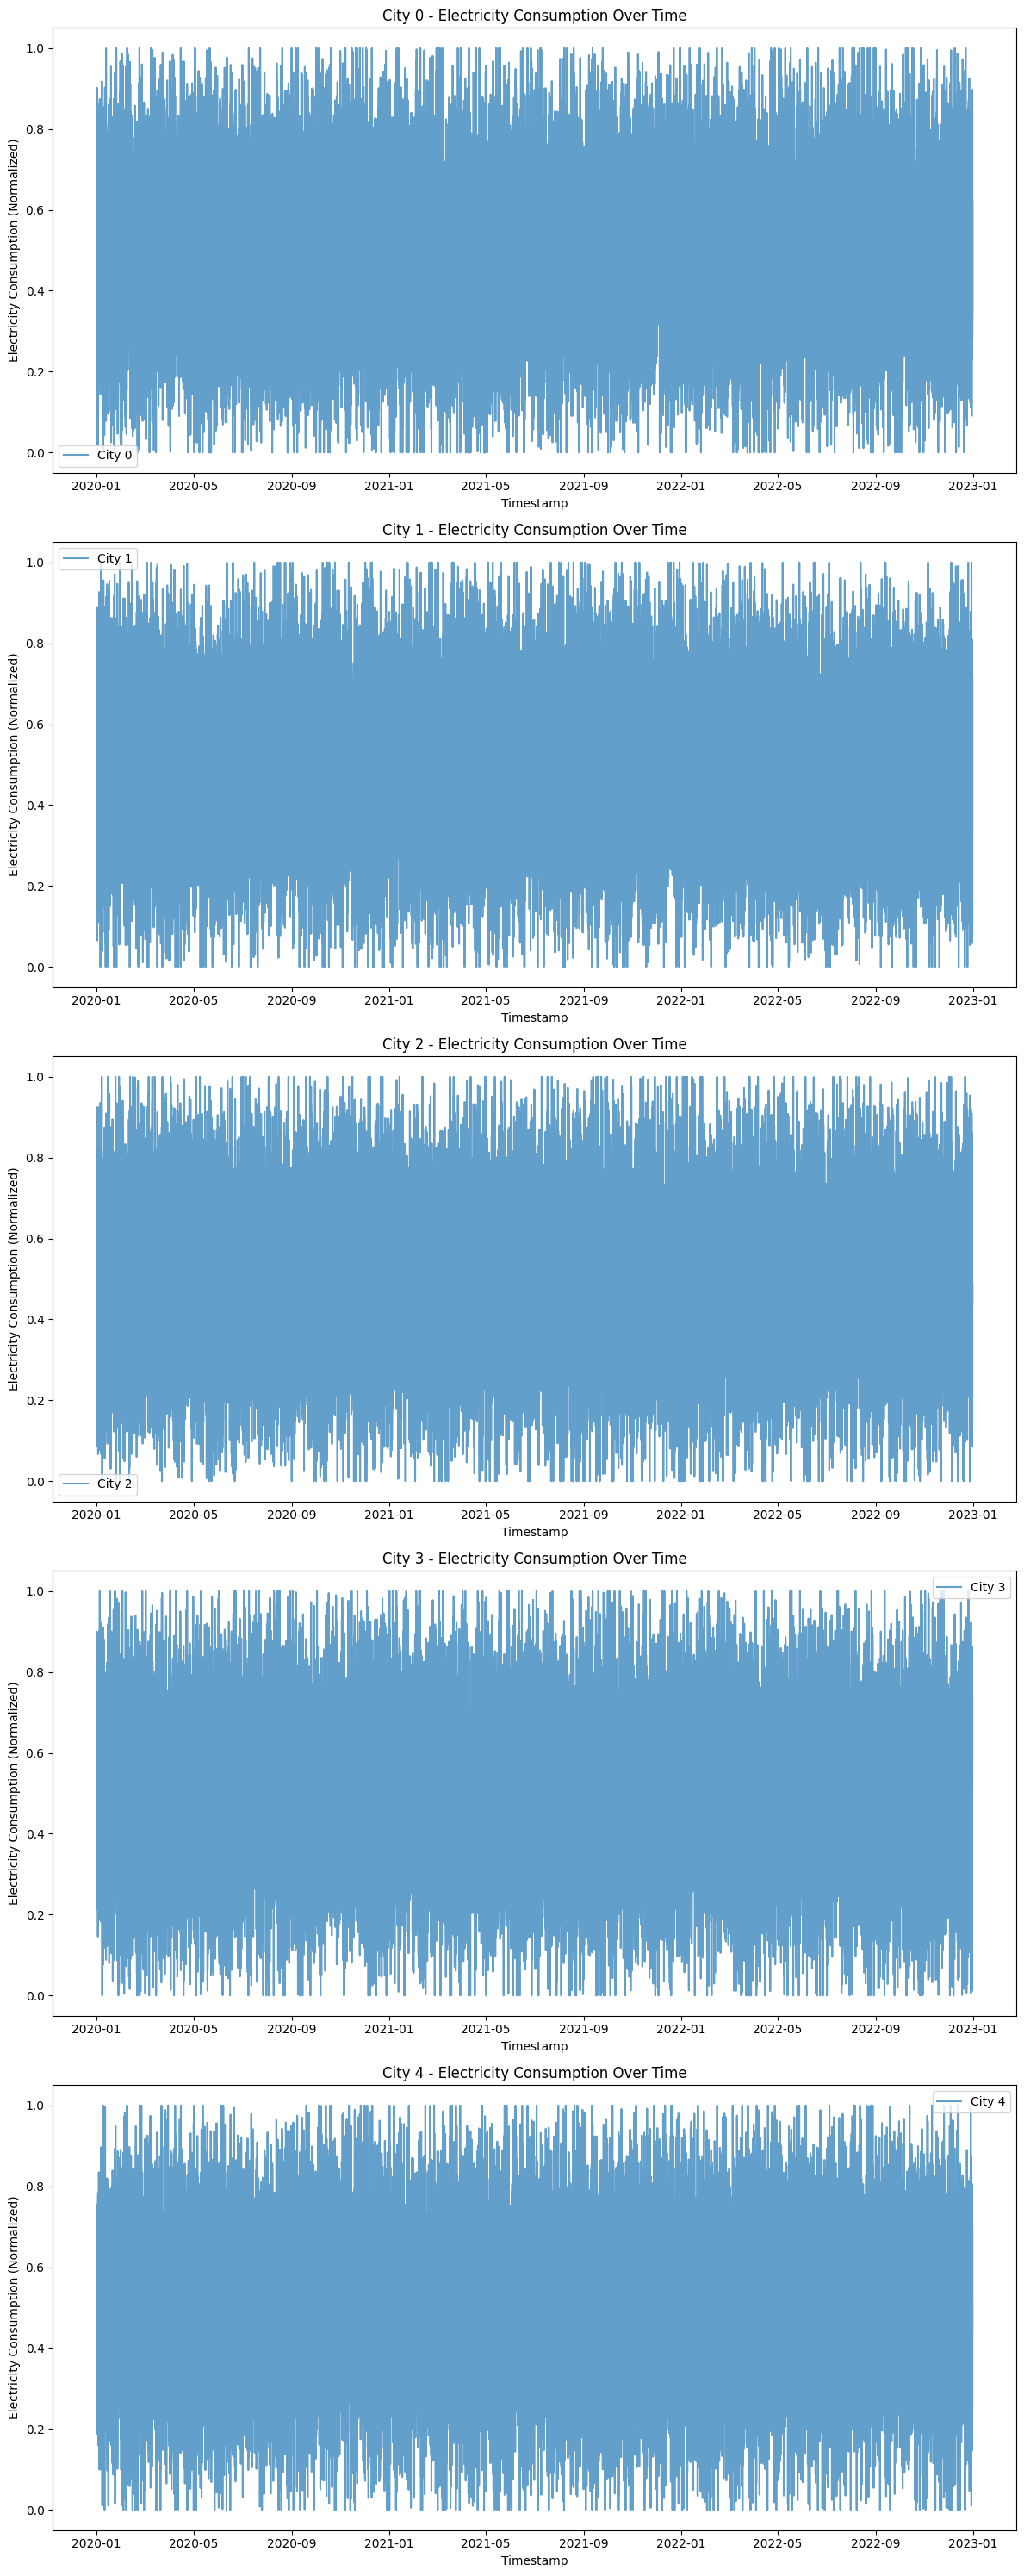

In [42]:
unique_cities = data['City_ID'].unique()

# Set up the figure with subplots
fig, axes = plt.subplots(len(unique_cities), 1, figsize=(12, 6 * len(unique_cities)))

# If there is only one subplot, axes will be a single Axes object, not an array
if len(unique_cities) == 1:
    axes = [axes]

# Plot electricity consumption for each city
for idx, city_id in enumerate(unique_cities):
    city_data = data[data['City_ID'] == city_id]
    axes[idx].plot(city_data['Timestamp'], city_data['Electricity_Consumption'], label=f"City {city_id}", alpha=0.7)
    axes[idx].set_title(f"City {city_id} - Electricity Consumption Over Time")
    axes[idx].set_xlabel("Timestamp")
    axes[idx].set_ylabel("Electricity Consumption (Normalized)")
    axes[idx].legend()

plt.tight_layout()
plt.show()


Correlation Matrix:
                         Temperature  Humidity  Electricity_Consumption
Temperature                 1.000000 -0.005336                 0.002256
Humidity                   -0.005336  1.000000                -0.002809
Electricity_Consumption     0.002256 -0.002809                 1.000000


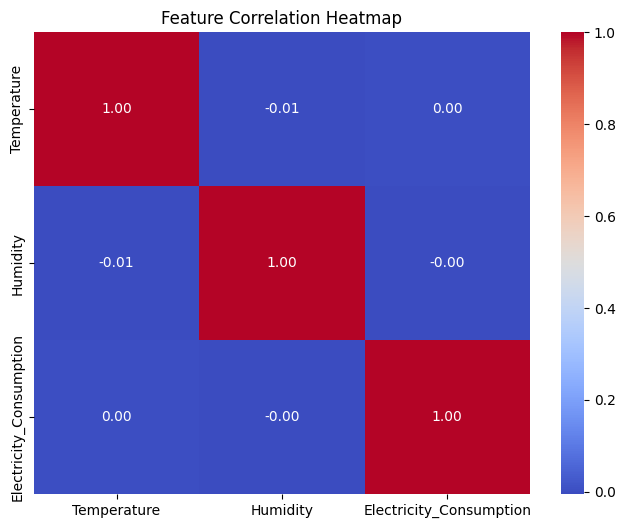

In [43]:
# Compute the correlation matrix
correlation_matrix = data[['Temperature', 'Humidity', 'Electricity_Consumption']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


Summary Statistics by City:
   City_ID  Electricity_Consumption_mean  Electricity_Consumption_std  \
0        0                      0.497020                     0.185488   
1        1                      0.495625                     0.184656   
2        2                      0.496654                     0.185263   
3        3                      0.496147                     0.185210   
4        4                      0.496454                     0.184662   

   Electricity_Consumption_max  Electricity_Consumption_min  Temperature_mean  \
0                          1.0                          0.0          0.487184   
1                          1.0                          0.0          0.485634   
2                          1.0                          0.0          0.487202   
3                          1.0                          0.0          0.487082   
4                          1.0                          0.0          0.485920   

   Humidity_mean  
0       0.499666  
1       

<ipython-input-44-6d40bdf77edb>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='City_ID', y='Electricity_Consumption_mean', data=city_summary, palette="viridis")


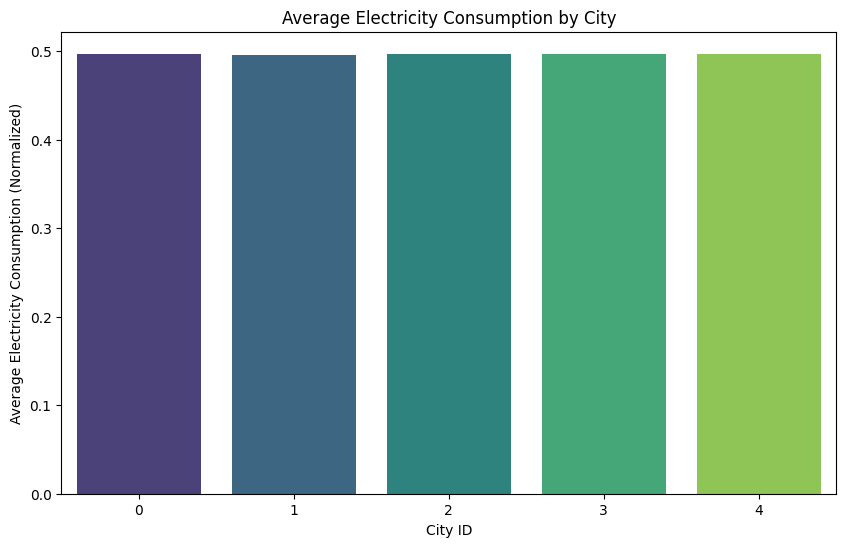

In [44]:
# Group data by city and calculate summary statistics
city_summary = data.groupby('City_ID').agg({
    'Electricity_Consumption': ['mean', 'std', 'max', 'min'],
    'Temperature': ['mean'],
    'Humidity': ['mean']
})

# Display the summary statistics
city_summary.columns = ['_'.join(col) for col in city_summary.columns]
city_summary.reset_index(inplace=True)
print("Summary Statistics by City:")
print(city_summary)

# Visualize the average electricity consumption per city
plt.figure(figsize=(10, 6))
sns.barplot(x='City_ID', y='Electricity_Consumption_mean', data=city_summary, palette="viridis")
plt.title("Average Electricity Consumption by City")
plt.xlabel("City ID")
plt.ylabel("Average Electricity Consumption (Normalized)")
plt.show()


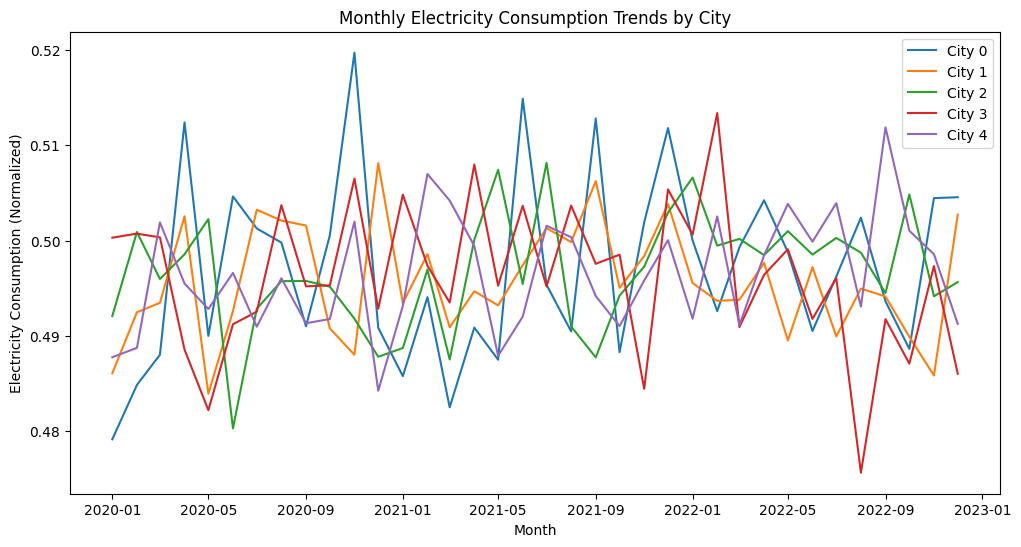

In [45]:
# Resample data to monthly frequency for trend analysis
data['Month'] = data['Timestamp'].dt.to_period('M')
monthly_data = data.groupby(['Month', 'City_ID']).mean().reset_index()

# Plot monthly electricity consumption trends for each city
plt.figure(figsize=(12, 6))
for city_id in data['City_ID'].unique():
    city_monthly = monthly_data[monthly_data['City_ID'] == city_id]
    plt.plot(city_monthly['Month'].dt.to_timestamp(), city_monthly['Electricity_Consumption'], label=f"City {city_id}")

plt.title("Monthly Electricity Consumption Trends by City")
plt.xlabel("Month")
plt.ylabel("Electricity Consumption (Normalized)")
plt.legend()
plt.show()


This is stupid. We need real data.